**Airbnb Calendar -Time-Series Analysis**

# Introduction

## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [16]:
#Read in libraries
import fbprophet
from fbprophet.plot import plot_plotly

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

**Read in Data**

In [17]:
#Set path to local machine for data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate/'

#Read in Airbnb Calendar data
calendar = pd.read_csv(path + '2020_0130_Calendar_Cleaned.csv', sep = ',',
                       parse_dates=['date'], low_memory=True,index_col=0)

#Read in Zillow data
zillow = pd.read_csv(path + '2020_0130_Zillow_Cleaned.csv', parse_dates=['Date'],
                     index_col=0, sep=',')

**Set notebook preferences**

In [18]:
#Set plot aesthetics for notebook
plt.style.use('ggplot')

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_rows',100)

#Set float format
pd.options.display.float_format = '{:.0f}'.format

#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Preview Data

## Airbnb Calendar Data

In [19]:
#View shape and preview calendar data
print(calendar.shape)
calendar.head()

(19950576, 5)


,index,available,date,listing_id,price
526,526,True,2017-07-31,8053481,220
527,527,True,2017-07-30,8053481,220
536,536,True,2017-07-21,8053481,230
537,537,True,2017-07-20,8053481,220
538,538,True,2017-07-19,8053481,220


## Zillow Data

In [20]:
#View shape and preview calendar data
print(zillow.shape)
zillow.head()

(277104, 9)


,City,County,Metro,Zip,State,SizeRank,Bedrooms,Date,Median_Rent
4928,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-03-01,1200
11368,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-04-01,1250
17808,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-05-01,1200
24248,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-06-01,1250
30688,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-07-01,1225


# Time Series Analysis

## Date preparation, indexing and feature engineering

### Calendar data preparation

In [21]:
#Set date as index in calendar
calendar.set_index('date', inplace=True)

#Get a count of the total number of Airbnb rental units per day
airbnbs = calendar.groupby(['date'])['listing_id'].count()
airbnbs = airbnbs.reset_index()

#Clean up airbnbs df
airbnbs.columns = ['date', 'available_units']
airbnbs.set_index('date', inplace=True)

### Zillow data preparation

In [22]:
#Set date as index
zillow.set_index('Date', inplace=True)

zillow.head()

,City,County,Metro,Zip,State,SizeRank,Bedrooms,Median_Rent
Date,,,,,,,,
2010-03-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1200
2010-04-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1250
2010-05-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1200
2010-06-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1250
2010-07-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1225


## Exploratory Data Analysis

            available_units
date                       
2016-12-03             1612
2016-12-04             2561
2016-12-05             2817
2016-12-06             2919
2016-12-07             2994


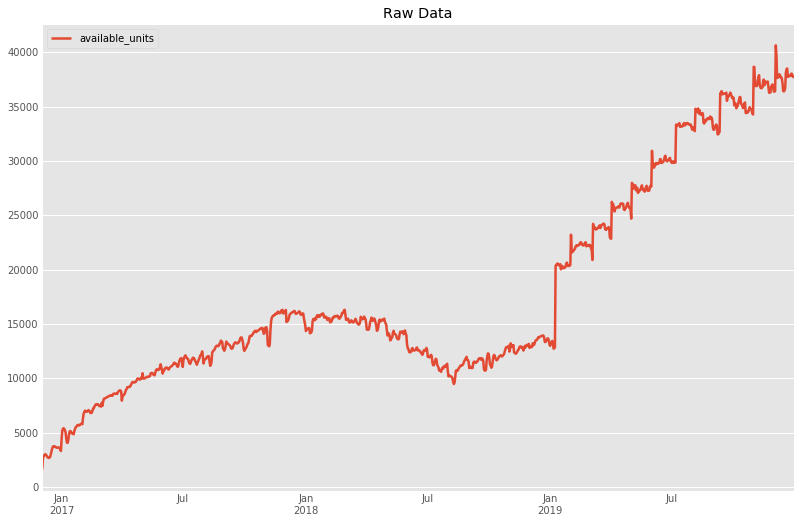

In [23]:
#Preview airbnbs data
print(airbnbs.head())

#Visualize airbnbs data
g = airbnbs.plot(figsize = (12,8),linewidth = 2.5, title = 'Raw Data',)
g.set_xlabel('')
g.grid(False, axis = 'x')

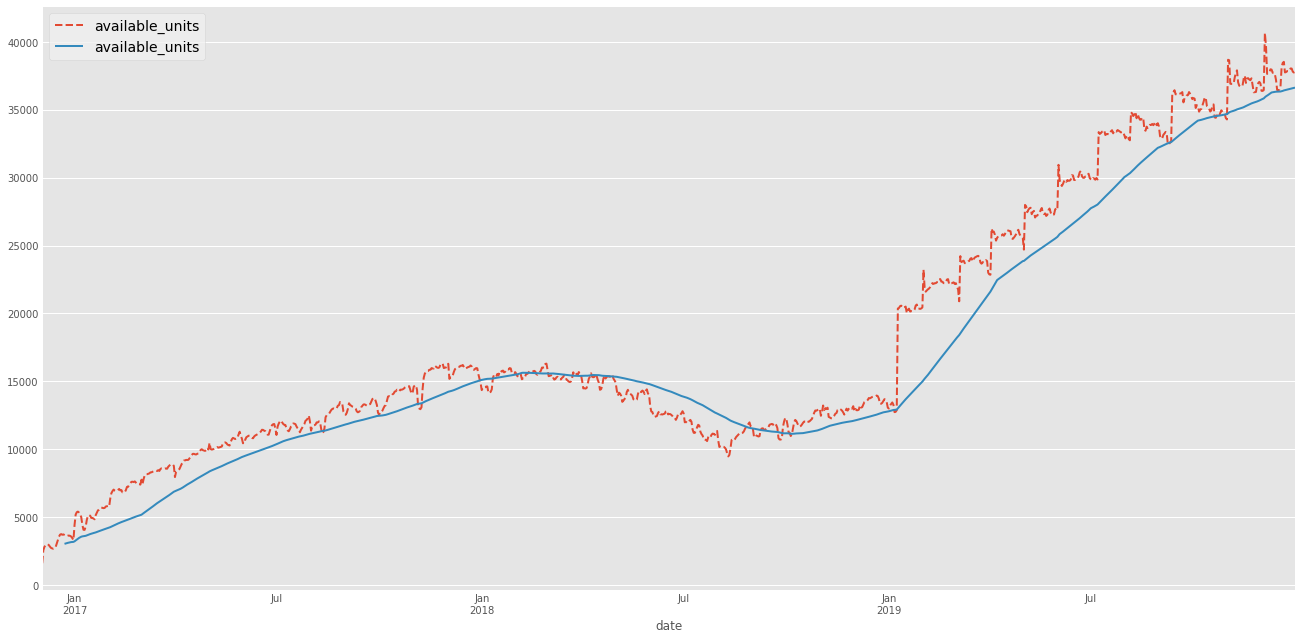

In [24]:
#Set plot
fig, ax = plt.subplots(figsize=(20,10))

#Set 538 plot style
plt.style.use('fivethirtyeight')

#Store count of booked evenings in Sf per night 
weekly_mean=airbnbs.rolling(window=7,min_periods=7).mean()
biweekly=airbnbs.rolling(window=14,min_periods=7).mean()
monthly=airbnbs.rolling(window=30,min_periods=21).mean()
quarterly=airbnbs.rolling(window=90,min_periods=21).mean()


#PLot count of booked nights per evening
airbnbs.plot(label = 'Daily Count',kind = 'line',style='--', linewidth=2,ax=ax)

#Plot rolling average per week
#weekly_mean.plot(label = 'Per Week',linewidth=2,ax=ax)
#biweekly.plot(label = 'Bi-weekly',linewidth=2,ax=ax)
#monthly.plot(label = 'Monthly',linewidth=2,ax=ax)
quarterly.plot(label = 'quarterly',linewidth=2,ax=ax)

#Set plot aesthetics
#ax.legend(fancybox = True, frameon=True, shadow = True)
ax.grid(False, axis = 'x')

## Airbnb Growth in SF(12/2016 - 12/2019)?

**Import Libraries**

In [25]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Naive Forecasting with moving average

In [26]:
def MovingAvg_Plot(series, time_window, confidence_intervals = False, scale=1.96,anomalies=False):
    """
    series: time-series data
    time-window: rolling window size
    plot_intervals - show confidence intervals
    anomalies - add anomalies to the plot
    """
    
    rolling_mean = series.rolling(window = time_window).mean()
    
    #Set plot for rolling mean
    plt.figure(figsize=(15,10))
    plt.plot(rolling_mean, label = 'Rolling Mean Trend', linewidth = 1., color ='g')
    plt.title('Moving Average\n Window Size = {}'.format(time_window))
        
    #Plot confidence intervals
    if confidence_intervals:
        mae = mean_absolute_error(series[time_window:], rolling_mean[time_window:])
        deviation = np.std(series[time_window:] - rolling_mean[time_window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond", color = 'black',linewidth = 1)
        plt.plot(lower_bond, "r--", color = 'black', linewidth = 1)
        
    #Find anomalies
    if anomalies:
        anomalies = pd.DataFrame(index = series.index, columns = series.columns)
        anomalies[series<lower_bond] = series[series<lower_bond]
        anomalies[series>upper_bond] = series[series>upper_bond]
        plt.plot(anomalies, 'o', markersize = 5)
        
    #Plot original data
    plt.plot(series[time_window:], label = 'Actual Values',linewidth = 1.)
    plt.legend(loc = 'upper left')


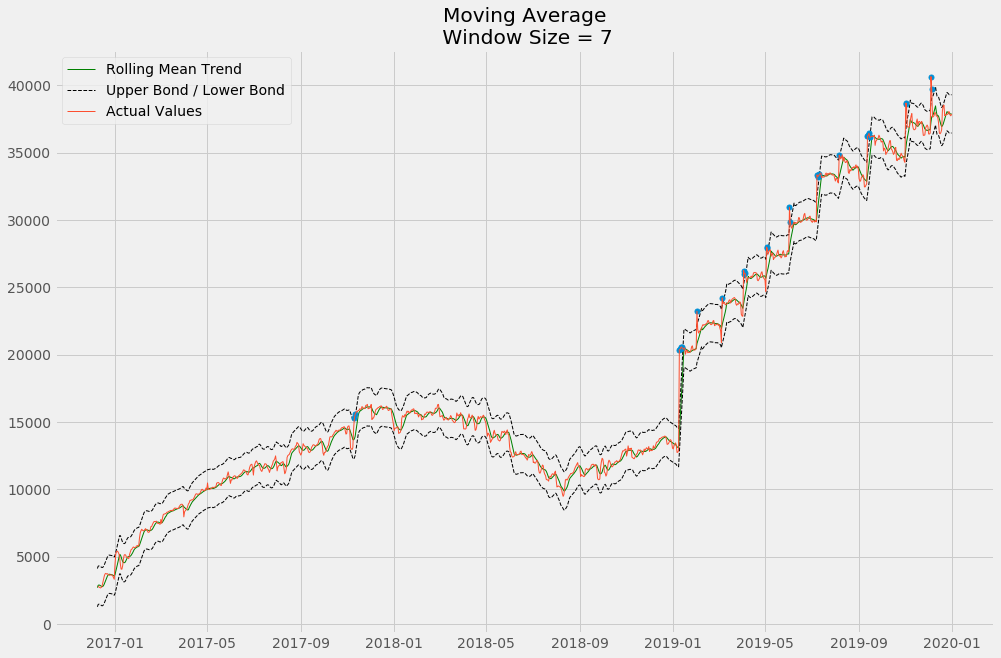

In [27]:
#Smoothing applied for a week
MovingAvg_Plot(airbnbs, 7, confidence_intervals=True, anomalies=True)

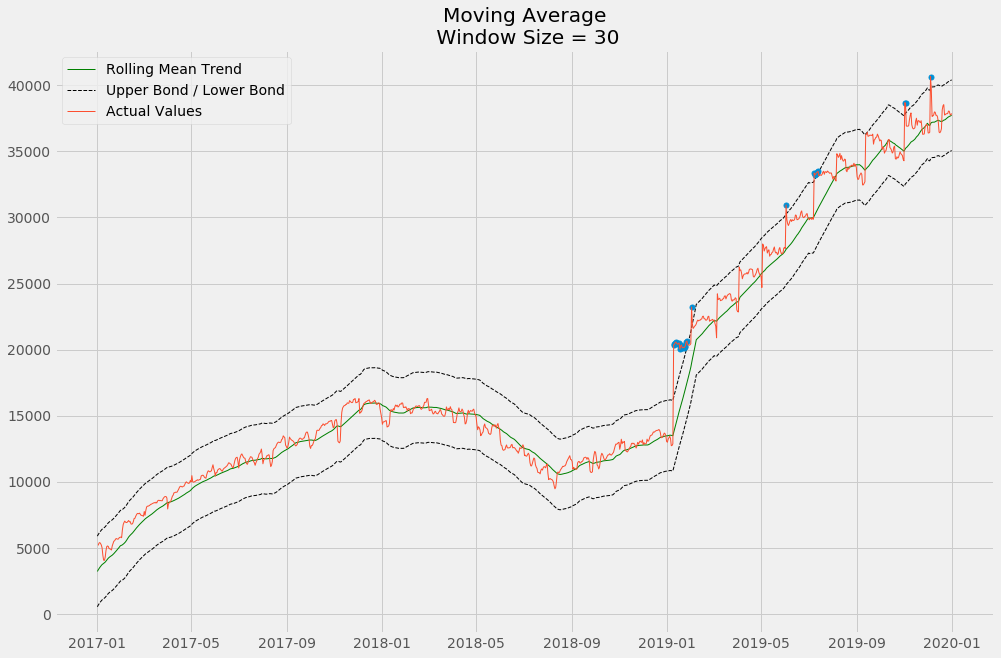

In [28]:
#Smoothing applied for a month
MovingAvg_Plot(airbnbs, 30, confidence_intervals=True, anomalies=True)

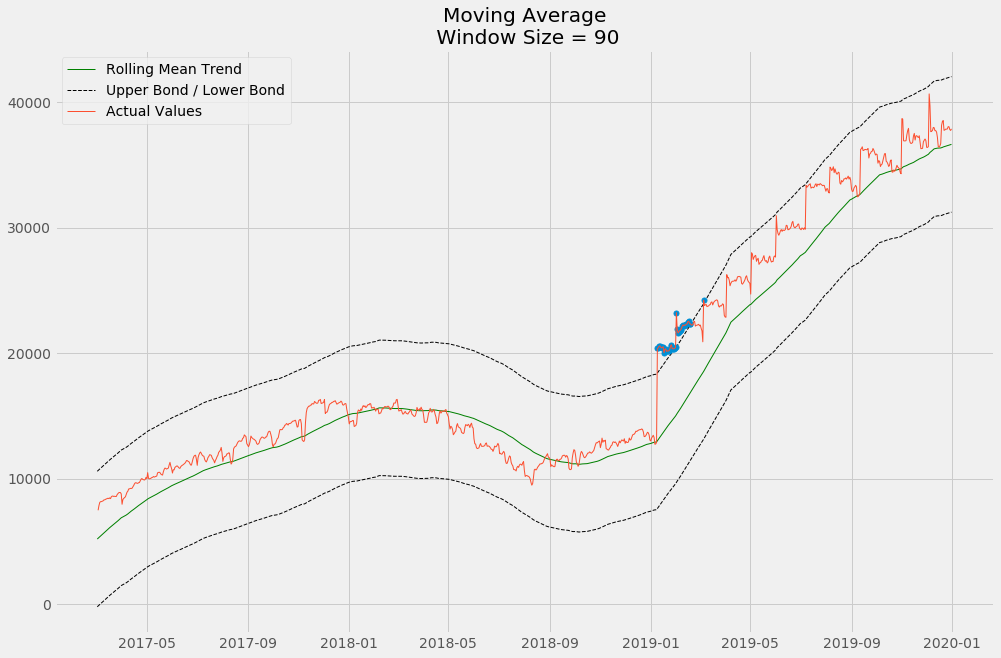

In [29]:
#Smoothing applied for a quarter
MovingAvg_Plot(airbnbs, 90, confidence_intervals=True, anomalies=True)

These models aren't too bad but let's see if we can improve upon these

### Airbnbn 2020 projections with Prophet

#### Prepare data for Prophet

In [30]:
#Rest index and rename cols for prophet model
prophet = airbnbs.reset_index()
prophet.rename(columns = {'date': 'ds', 'available_units':'y'}, inplace = True)

In [31]:
#Init prophet and fit to data
model = fbprophet.Prophet(changepoint_prior_scale=.05)

model.fit(prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
#Make forecast df for Q1 in 2020
future = model.make_future_dataframe(periods=91, freq='D')

#Make predictions
forecast = model.predict(future)

In [33]:
#View Predictions
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1205,2020-03-22,46590,45069,48025
1206,2020-03-23,46660,44993,48188
1207,2020-03-24,46716,45254,48232
1208,2020-03-25,46873,45309,48383
1209,2020-03-26,46943,45333,48525
1210,2020-03-27,47126,45583,48780
1211,2020-03-28,47168,45644,48697
1212,2020-03-29,47106,45380,48683
1213,2020-03-30,47183,45556,48752
1214,2020-03-31,47244,45659,48874


Text(0.5, 1, 'Prophet Projections Through Q1')

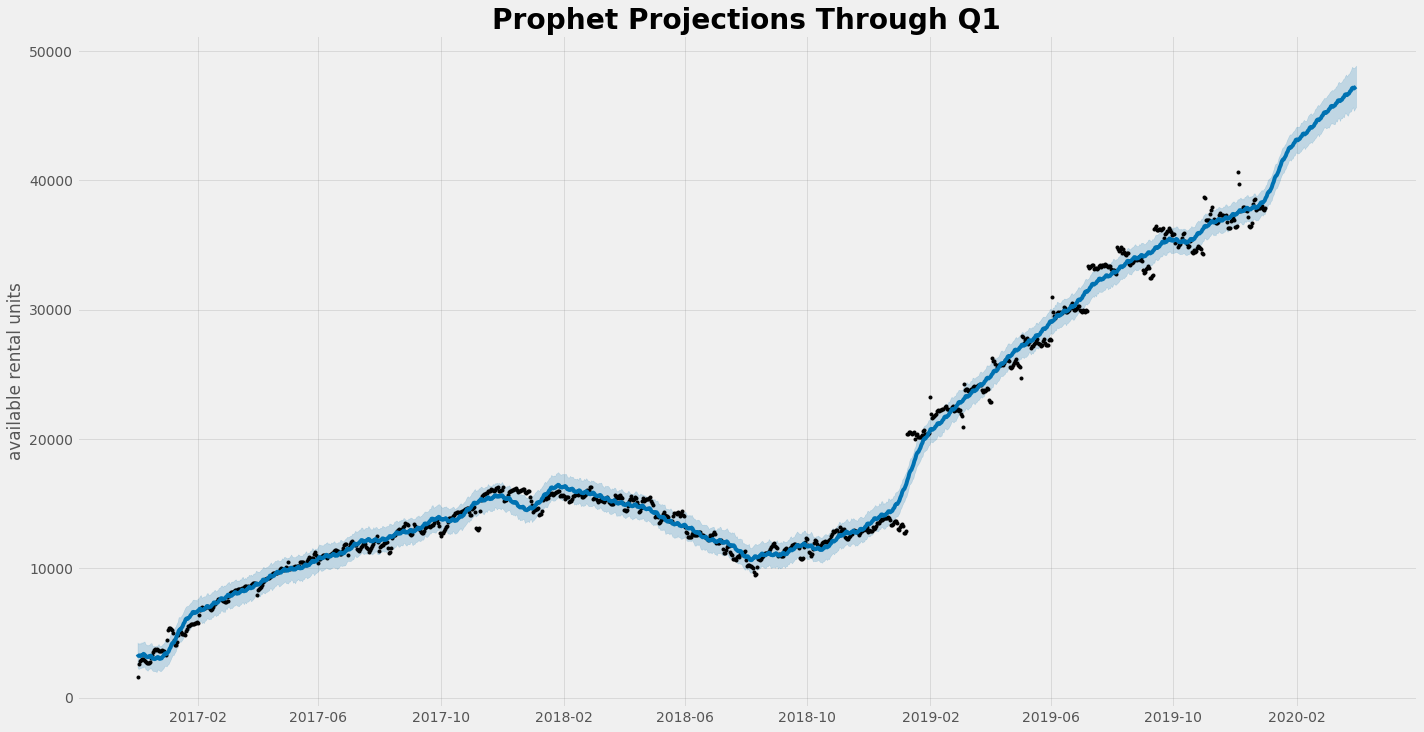

In [34]:
#Set plot
fig, ax = plt.subplots(figsize=(20,10))

model.plot(forecast, xlabel='', ylabel='available rental units', ax=ax);

#Set Plot Aeisthetics
ax.set_title('Prophet Projections Through Q1', fontweight = 'bold', fontsize = 28)

# Median rent across the United States

(504, 598)

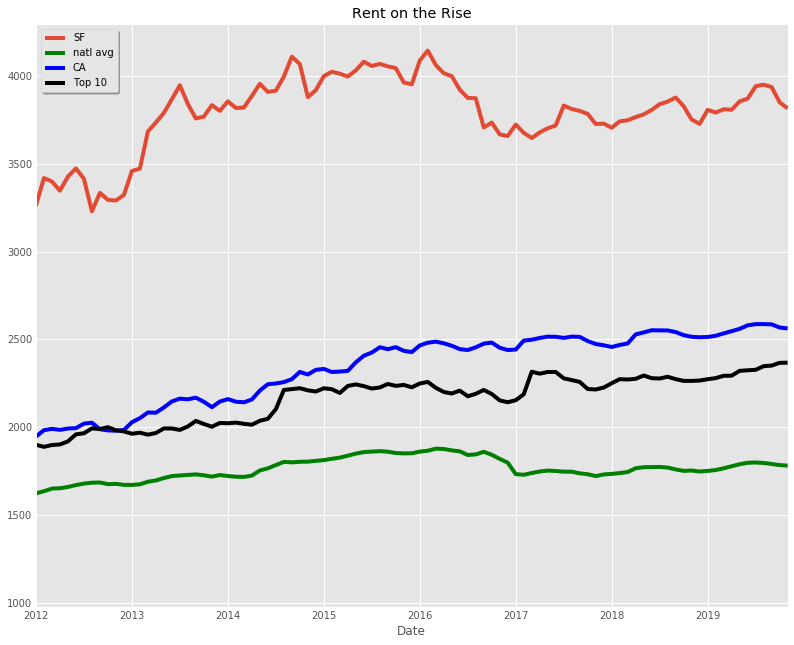

In [35]:
#SF vs rest of US Rent

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (12,10))
ax1 = zillow[zillow.City == 'San Francisco'].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line',
                                                                            label= 'SF', ax=ax)
ax2 = zillow.groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color= 'g', label = 'natl avg')#natl average

#We also noted each state's region size ranking, which represents how big it is population-wise;
#California is ranked No. 1 with the largest population of all states, while Wyoming is ranked No. 51
ax3 = zillow[zillow.State == 'CA'].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color = 'b', label= 'CA',
                                                                               )#this is compared to CA

ax4 = zillow.loc[(zillow.State != 'CA') & (zillow.SizeRank.isin(np.arange(1,15)))].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color = 'black',
                                                                         label = 'Top 10',
                                                                            )#purp(top 10 largest cities in US)


plt.title('Rent on the Rise')
ax.legend(fancybox = True, frameon=True, shadow = True)
ax.set_xlim(['2012', '2019-11-01'])   # set the xlim to left, right


Can Airbnb be an viable option for a 1-month stay in SF?

(576, 598)

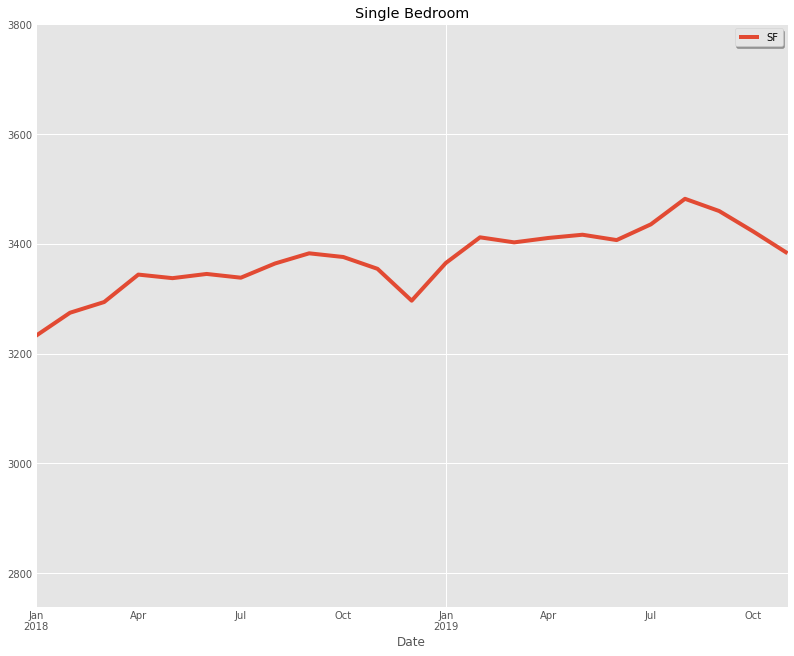

In [36]:
fig, ax = plt.subplots(figsize = (12,10))
ax1 = zillow.loc[(zillow.Bedrooms == 1) & (zillow.City == 'San Francisco')].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line',
                                                                            label= 'SF', ax=ax)


plt.title('Single Bedroom')
ax.legend(fancybox = True, frameon=True, shadow = True)
ax.set_xlim(['2018', '2019-11-01'])   # set the xlim to left, right

In [37]:
calendar.head()

,index,available,listing_id,price
date,,,,
2017-07-31,526,True,8053481,220
2017-07-30,527,True,8053481,220
2017-07-21,536,True,8053481,230
2017-07-20,537,True,8053481,220
2017-07-19,538,True,8053481,220


* Comparing monthly rent of airbnb to zillow

### Principal Component Analysis